# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

Write the problem in your own words here
This is a regression problem to predict the salaries for new job postings from the existing data.

In [5]:
#import libraries
##for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
#import sklearn as sk

## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
## for explainer
#from lime import lime_tabular


#your info here
__author__ = "Ancy John"
__email__ = "ancy.14@gmail.com"

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [6]:
# For uploading files
from google.colab import files
uploaded = files.upload()

Saving train_features.csv to train_features (1).csv
Saving train_salaries.csv to train_salaries (1).csv


In [7]:
#load the data into a Pandas dataframe
data1 = pd.read_csv("train_features.csv")
data1.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [ ]:
data1.shape # To view the structure of the dataframe

(1000000, 8)

In [ ]:
data1.isnull().sum() # To check for the null values

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
dtype: int64

In [ ]:
# Define a function to visualize the dataframe datatypes
def utils_recognize_type(data, col, max_cat=20):
    if (data[col].dtype == "O") | (data[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

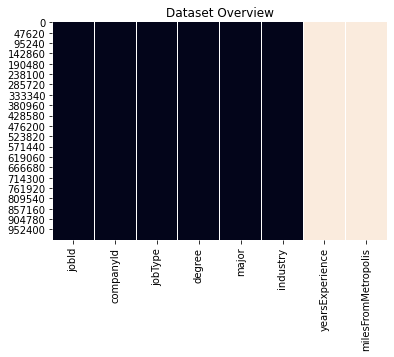

 Categerocial   Numeric   NaN 


In [ ]:
dic_cols = {col:utils_recognize_type(data1, col, max_cat=20) for col in data1.columns}
heatmap = data1.isnull()
for k,v in dic_cols.items():
 if v == "num":
   heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
 else:
   heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)
sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')
plt.show()
print("\033[1;37;40m Categerocial ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")

In [ ]:
data1.info() # info on columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [8]:
data2 = pd.read_csv("train_salaries.csv")
data2.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [ ]:
data2.info()

In [ ]:
data2.isnull().sum() # To check for the null values

jobId     0
salary    0
dtype: int64

### ---- 3 Clean the data ----
#look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it

/home/ancy/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ancy/.local/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


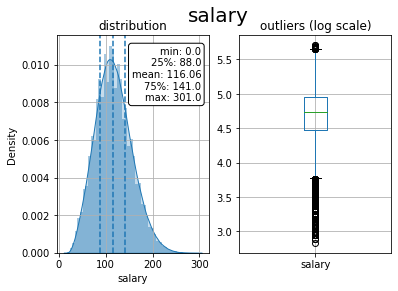

In [ ]:
# Distribution of the target variable
x = "salary"
fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False)
fig.suptitle(x, fontsize=20)
### distribution
ax[0].title.set_text('distribution')
variable = data2[x].fillna(data2[x].mean())
#variable = data2[x].apply(np.log) #Log transformed target variable
#variable = variable.fillna(variable.mean()) 
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
variable = variable[ (variable > breaks[0]) & (variable < 
                    breaks[10]) ]
sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
des = data2[x].describe()
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))

### boxplot 
ax[1].title.set_text('outliers (log scale)')
tmp_dtf = pd.DataFrame(data2[x])
tmp_dtf[x] = np.log(tmp_dtf[x])
tmp_dtf.boxplot(column=x, ax=ax[1])
plt.show()

No negative values for 'salary' the target variable. We do not have to log transform the target variable as the data is almost symmetrical.

In [ ]:
data1[['yearsExperience','milesFromMetropolis']].min() # To check for the minimum values

yearsExperience        0
milesFromMetropolis    0
dtype: int64

In [ ]:
data2.min(numeric_only=True)

salary    0
dtype: int64

### ---- 4 Explore the data (EDA) ----


In [9]:
#To set indexing for the dataframe
data1 = data1.set_index("jobId")
data2 = data2.set_index("jobId")

In [10]:
#Merging datasets at the index
data = data1.join(data2)
#data.head()

In [ ]:
data.duplicated().sum() #Checking duplicated rows

186

In [ ]:
data.shape

(1000000, 8)

In [11]:
data.drop_duplicates(subset=None, keep='first', inplace=False) #To drop duplicate rows

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
jobId,,,,,,,,
JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163
...,...,...,...,...,...,...,...,...
JOB1362685407682,COMP56,VICE_PRESIDENT,BACHELORS,CHEMISTRY,HEALTH,19,94,88
JOB1362685407683,COMP24,CTO,HIGH_SCHOOL,NONE,FINANCE,12,35,160
JOB1362685407684,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81,64


In [ ]:
data.corr() #Correlation between the numeric columns

,yearsExperience,milesFromMetropolis,salary
yearsExperience,1.000000,0.000673,0.375013
milesFromMetropolis,0.000673,1.000000,-0.297666
salary,0.375013,-0.297666,1.000000


In [ ]:
#To convert dtype
#data = data.select_dtypes(include= 'object').astype('category') 
#data.info()

In [ ]:
print(data.nunique()) # Count of distinct values in each column

companyId               63
jobType                  8
degree                   5
major                    9
industry                 7
yearsExperience         25
milesFromMetropolis    100
salary                 280
dtype: int64


Feature distributions: to visualize the relationship between the features and the response.
We use bar plots for categorical features and scatter plots for numerical features.

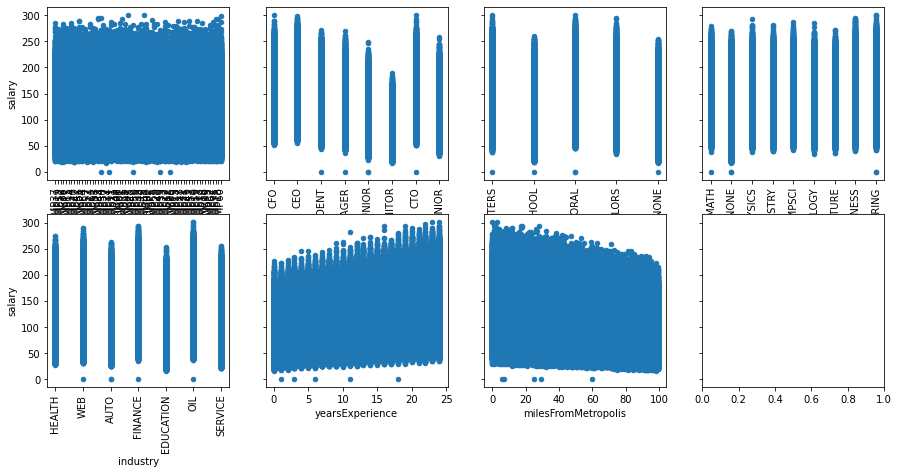

In [ ]:
fig, axs = plt.subplots(2, 4, sharey=True)
data.plot(kind='scatter', x='companyId', y='salary', ax=axs[0,0], figsize=(15, 7), rot=90)
data.plot(kind='scatter', x='jobType', y='salary', ax=axs[0,1], rot=90)
data.plot(kind='scatter', x='degree', y='salary', ax=axs[0,2], rot=90)
data.plot(kind='scatter', x='major', y='salary', ax=axs[0,3], rot=90)
data.plot(kind='scatter', x='industry', y='salary', ax=axs[1,0], rot=90)
data.plot(kind='scatter', x='yearsExperience', y='salary', ax=axs[1,1])
data.plot(kind='scatter', x='milesFromMetropolis', y='salary', ax=axs[1,2])
plt.show()

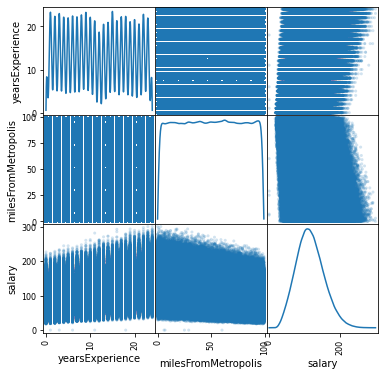

In [ ]:
from pandas.plotting import scatter_matrix
scatter_matrix(data, alpha=0.2, figsize=(6, 6), diagonal="kde");

In [ ]:
data.head()

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
jobId,,,,,,,,
JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [12]:
# Label encoding for ordinal categorical features
data_encoded = data.copy(deep = True) #to create a copy for the dataframe
le = preprocessing.LabelEncoder()
data_encoded['companyId'] = le.fit_transform(data_encoded['companyId'])
data_encoded['jobType'] = le.fit_transform(data_encoded.jobType.values)
data_encoded['degree'] = le.fit_transform(data_encoded['degree'])
data_encoded['major'] = le.fit_transform(data_encoded['major'])
data_encoded['industry'] = le.fit_transform(data_encoded.industry.values)
data_encoded.head()

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
jobId,,,,,,,,
JOB1362684407687,31,1,3,6,3,10,83,130
JOB1362684407688,11,0,2,7,6,3,73,101
JOB1362684407689,48,7,1,8,3,10,38,137
JOB1362684407690,32,5,1,2,0,8,17,142
JOB1362684407691,60,7,0,8,2,8,16,163


In [ ]:
print(data.nunique()) # unique column values

companyId               63
jobType                  8
degree                   5
major                    9
industry                 7
yearsExperience         25
milesFromMetropolis    100
salary                 280
dtype: int64


In [ ]:
print(data_encoded.nunique()) # unique column values

companyId               63
jobType                  8
degree                   5
major                    9
industry                 7
yearsExperience         25
milesFromMetropolis    100
salary                 280
dtype: int64


In [ ]:
data_encoded.corr() # Checking orrelation after label encoding

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
companyId,1.000000,-0.000284,-0.000057,0.000780,-0.001446,0.001185,-0.001020,-0.000993
jobType,-0.000284,1.000000,-0.020084,-0.020774,0.000069,-0.000186,-0.000365,-0.228673
degree,-0.000057,-0.020084,1.000000,0.370089,0.001551,-0.000144,-0.001359,-0.231789
major,0.000780,-0.020774,0.370089,1.000000,0.001075,0.000012,-0.001369,-0.262430
industry,-0.001446,0.000069,0.001551,0.001075,1.000000,0.000263,-0.000819,0.086502
yearsExperience,0.001185,-0.000186,-0.000144,0.000012,0.000263,1.000000,0.000673,0.375013
milesFromMetropolis,-0.001020,-0.000365,-0.001359,-0.001369,-0.000819,0.000673,1.000000,-0.297666
salary,-0.000993,-0.228673,-0.231789,-0.262430,0.086502,0.375013,-0.297666,1.000000


In [13]:
# Define a function to visualize correlation
def crossCorrelation(data):
    corr = data.corr()
    plt.figure(figsize=(10,6))
    sns.heatmap(corr, 
          xticklabels=corr.columns.values,
          yticklabels=corr.columns.values,
          annot = True)
    #print(corr)

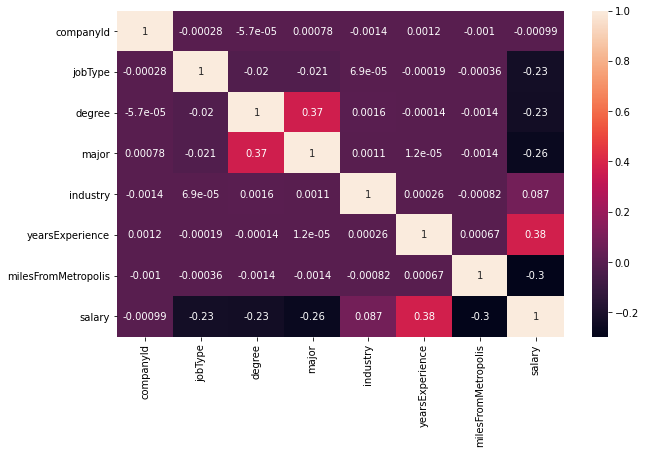

In [14]:
crossCorrelation(data_encoded)

There is a negative correlation between 'milesFromMetropolis' and the target variable. Such a negative correlation is visible with the feature variable 'major' as well. Target variable 'salary' has a positive correlation with 'yearsExperience'.

Also there is a multicollinearity between the features 'degree' and 'major'.

### ---- 5 Establish a baseline ----

We will begin with simple linear regression as a baseline model.

<AxesSubplot:xlabel='yearsExperience'>

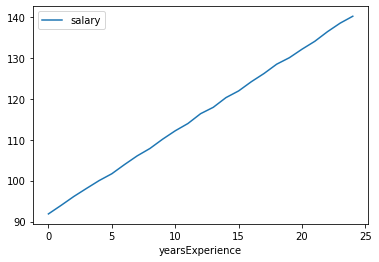

In [ ]:
#Average salary with years of experience
df = data_encoded[['yearsExperience','salary']].groupby(['yearsExperience']).mean()
#df.head()
df.plot()

Apparently there is a linear relation between the predictor and the target

In [ ]:
df.head()

,salary
yearsExperience,
0,91.873541
1,93.960040
2,96.125184
3,98.090368
4,100.014112


In [ ]:
# Import Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#df.reset_index(level=0, inplace=True) #To convert index into a column
x = data.yearsExperience.values
y = data.salary.values
#To reshape the array. fit() fuction expects a 2d array object
length = data.shape[0]
x = x.reshape(length, 1)
y = y.reshape(length, 1)
x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.20, random_state=14)

lr = LinearRegression()
lr.fit(x_tr,y_tr)

LinearRegression()

In [ ]:
#df.shape

(25, 2)

In [ ]:
print(lr.intercept_) #y intercept
print(lr.coef_) #beta coefficients

[91.9193465]
[[2.01315181]]


In [ ]:
X = test_f['yearsExperience']
#length = test_f.shape[0]
X = X.values.reshape(len(X), 1)

In [ ]:
pred = lr.predict(x_te)

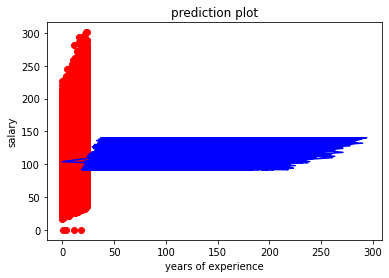

In [ ]:
#Prediction plot
plt.scatter(x_tr, y_tr, color = 'red')
plt.plot(y_te, pred, color = 'blue')
plt.title('prediction plot')
plt.xlabel('years of experience')
plt.ylabel('salary')
plt.show()

In [ ]:
#Import metrics library
from sklearn import metrics
print(metrics.mean_squared_error(y_te, pred))

1282.5527978966027


In [ ]:
#x_tr.shape
#y_tr.shape
#x_te.shape
#y_te.shape

(750000, 1)

In [ ]:
# 5-fold cross validation
#from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
model = LinearRegression()
mse = cross_val_score(model, x, y, scoring='neg_mean_squared_error')
print(mse)

[-1290.40791491 -1288.17305792 -1294.70258327 -1286.86575461
 -1281.16974579]


Metrics which measure the distance between the model and the data returns the negated value of the metric. Number of folds is 5 by default. Cross validated scores did not make any improvement in the test error value. 

### ---- 6 Hypothesize solution ----

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

In [ ]:
# Multiple Linear regression using statsmodels
import statsmodels.api as sm

# Define X Values
X = sm.add_constant(data_encoded.drop(['salary'], axis=1))          

# Define Y 
Y = data_encoded['salary']

# Apply OLS to our X and Y
lm = sm.OLS(Y, X).fit()

# Print Summary of Outputs
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                 8.862e+04
Date:                Tue, 09 Mar 2021   Prob (F-statistic):               0.00
Time:                        19:34:40   Log-Likelihood:            -4.8339e+06
No. Observations:             1000000   AIC:                         9.668e+06
Df Residuals:                  999992   BIC:                         9.668e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 148.3696      0.136   1090.249      0.000     148.103     148.636
companyId              -0.0033      0.002     -1.948      0.051      -0.007    2.04e-05
jobType                -3.9916      0.013   -300.652      0.000      -4.018      -3.966
degree                 -4.3908      0.023   -188.927      0.000      -4.436      -4.345
major                  -3.3686      0.014   -246.782      0.000      -3.395      -3.342
industry                1.6768      0.015    110.292      0.000       1.647       1.707
yearsExperience         2.0138      0.004    477.507      0.000       2.006       2.022
milesFromMetropolis    -0.4001      0.001   -379.887      0.000      -0.402      -0.398
==============================================================================
Omnibus:                    11237.008   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10562.228
Skew:                           0.218   Prob(JB):                         0.00
Kurtosis:                       2.747   Cond. No.                         294.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# To check multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = data_encoded.drop(['salary'],axis=1).assign(const=1)
pd.Series([variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])],index=X_vif.columns)

companyId               1.000005
jobType                 1.000610
degree                  1.158913
major                   1.158945
industry                1.000006
yearsExperience         1.000002
milesFromMetropolis     1.000005
const                  20.017779
dtype: float64

Clearly the features degree and major are slightly correlated while other features and not correlated

/home/ancy/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Residuals')

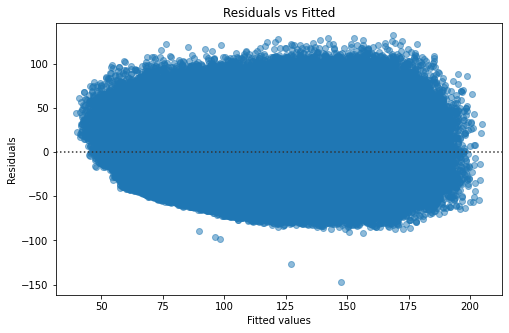

In [ ]:
# Create residual plot of salary vs Residuals
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(5)
plot_lm_1.set_figwidth(8)

model_fitted_y = lm.fittedvalues

plot_lm_1.axes[0] = sns.residplot(model_fitted_y, 'salary', data=data, 
                          scatter_kws={'alpha': 0.5})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

The errors exhibit constant variance.

/home/ancy/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


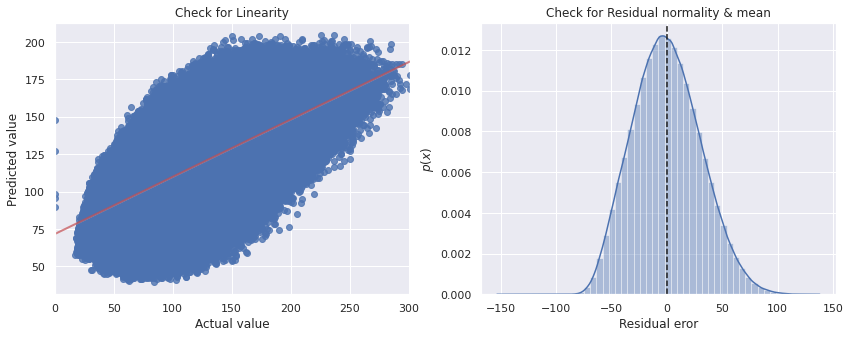

In [ ]:
#To detect linearity and the distribution of the residuals
import seaborn as sns; sns.set()

# Check for Linearity
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)

# use the function regplot to make a scatterplot
sns.regplot(x=data_encoded.salary, y=model_fitted_y, line_kws={"color":"r","alpha":0.7,"lw":2})
plt.title('Check for Linearity')
plt.xlabel('Actual value')
plt.ylabel('Predicted value')

# Check for Residual normality & mean
ax = f.add_subplot(122)
sns.distplot((data_encoded.salary - model_fitted_y),ax=ax,color='b')
plt.axvline((data_encoded.salary - model_fitted_y).mean(),color='k',linestyle='--')
plt.title('Check for Residual normality & mean')
plt.xlabel('Residual eror')
plt.ylabel('$p(x)$');

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

In [ ]:
# Import Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#df.reset_index(level=0, inplace=True) #To convert index into a column
x = data_encoded.drop(['salary'],axis=1)
y = data_encoded.salary.values

x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.20, random_state=14)
#initialize the model
lr = LinearRegression()

#fit the model
lr.fit(x_tr,y_tr)

# Make predictions
predictions = lr.predict(x_te)

In [ ]:
#MSE
from sklearn import metrics
print(metrics.mean_squared_error(y_te, predictions))

927.2449926302991


In [ ]:
# 5-fold cross validation
from sklearn.model_selection import cross_val_score
mse = cross_val_score(lr, x, y, scoring='neg_mean_squared_error')
print(mse)

[-927.140229   -925.90398522 -928.49891064 -925.71098177 -918.64432812]


Multiple feature addition to the model has made quite an improvement in MSE.

In [ ]:
## Multiple nonlinear regression
#Polynomial regression fit a model to nonlinear trends
from sklearn.preprocessing import PolynomialFeatures
polyfeat = PolynomialFeatures(degree=5)
X_trainpoly = polyfeat.fit_transform(x_tr)
X_testpoly = polyfeat.fit_transform(x_te)
poly = LinearRegression().fit(X_trainpoly, y_tr)

predp = poly.predict(X_testpoly)

In [ ]:
print(metrics.mean_squared_error(y_te, predp))

521.0350168440332


Capturing nonlinear trends in the data improved the mse score.

### ---- 7 Engineer features  ----

In [ ]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model
# We create a new categorical feature 'edu_level' based on the existing features 'degree' and 'major'.   
def edu_level(df):
    if df['degree'] == 'MASTERS' or df['degree'] == 'DOCTORAL':
        return 'High'
    elif df['degree'] == 'BACHELORS':
        return 'Medium'
    else:
        return 'Low/Nil'

In [ ]:
# feature edu_level for each person
data['edu_level'] = data.apply(edu_level, axis=1)

In [ ]:
# Label encoding with new features
data_encoded = data.copy(deep = True) #to create a copy for the dataframe
le = preprocessing.LabelEncoder()
data_encoded['companyId'] = le.fit_transform(data_encoded['companyId'])
data_encoded['jobType'] = le.fit_transform(data_encoded.jobType.values)
data_encoded['degree'] = le.fit_transform(data_encoded['degree'])
data_encoded['major'] = le.fit_transform(data_encoded['major'])
data_encoded['industry'] = le.fit_transform(data_encoded.industry.values)
data_encoded['edu_level'] = le.fit_transform(data_encoded.edu_level.values)
data_encoded.head()

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,edu_level
jobId,,,,,,,,,
JOB1362684407687,31,1,3,6,3,10,83,130,0
JOB1362684407688,11,0,2,7,6,3,73,101,1
JOB1362684407689,48,7,1,8,3,10,38,137,0
JOB1362684407690,32,5,1,2,0,8,17,142,0
JOB1362684407691,60,7,0,8,2,8,16,163,2


### ---- 8 Create models ----

In [ ]:
#create and tune the models that you brainstormed during part 2
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import train_test_split
#df.reset_index(level=0, inplace=True) #To convert index into a column
x = data_encoded.drop(['salary'],axis=1)
y = data_encoded.salary.values

x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.20, random_state=14)

### ---- 9 Test models ----

In [ ]:
#do 5-fold cross validation on models and measure MSE
from sklearn.model_selection import GridSearchCV
model = xgb.XGBRegressor()
# Define Parameters
param_grid = {"max_depth": [5,50],
              "min_child_weight" : [5,10],
              "n_estimators": [440,470],
              #'objective':'reg:squarederror',
              "learning_rate": [0.09,0.1]}

# Perform Grid Search CV
gs_cv = GridSearchCV(model, param_grid=param_grid, cv = 5, verbose=10, n_jobs=-1 ).fit(x_tr, y_tr)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 40.3min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 57.5min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 91.6min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 119.3min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 158.5min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 199.7min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 250.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 262.4min finished


[07:46:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
import xgboost as xgb
model3 = xgb.XGBRegressor(max_depth=50,n_estimators=440,learning_rate=0.09)
model3.fit(x_tr,y_tr)

[08:13:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.09, max_delta_step=0,
             max_depth=50, min_child_weight=1, missing=None, n_estimators=440,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
from sklearn import metrics
y_pred = model3.predict(x_te)
print(metrics.mean_squared_error(y_te, y_pred))

443.12000900931156


### ---- 10 Select best model  ----

In [ ]:
#select the model with the lowest error as your "prodcuction" model
#select the model with the lowest error as your "prodcuction" model
best_model = gs_cv.best_estimator_

In [ ]:
best_model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.09, max_delta_step=0,
             max_depth=5, min_child_weight=5, missing=None, n_estimators=440,
             n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
eval_set = [(x_tr, y_tr), (x_te, y_te)]
best_model.fit(x_tr,y_tr,eval_set=eval_set, verbose=False, early_stopping_rounds=10)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.09, max_delta_step=0,
             max_depth=5, min_child_weight=5, missing=None, n_estimators=440,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
from sklearn import metrics
y_pred = best_model.predict(x_te)
print(metrics.mean_squared_error(y_te, y_pred))

355.3818583377987


Text(0.5, 1.0, 'XGBoost RMSE')

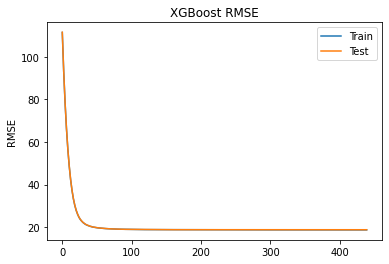

In [ ]:
# Retrieve performance metrics
predictions = [round(value) for value in y_pred]
results = best_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# Plot log loss curve
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

write script that trains model on entire training set, saves model to disk,and scores the "test" dataset

In [ ]:
# Train the model on the entire training data
best_model.fit(x,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.09, max_delta_step=0,
             max_depth=5, min_child_weight=5, missing=None, n_estimators=440,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test_features.csv to test_features.csv


In [ ]:
test = pd.read_csv("test_features.csv")
test.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


In [ ]:
test = test.set_index("jobId")
test.head()

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
jobId,,,,,,,
JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


In [ ]:
test['edu_level'] = test.apply(edu_level, axis=1)

test.edu_level.value_counts()

Low/Nil    475722
High       350341
Medium     173937
Name: edu_level, dtype: int64

In [ ]:
# Label encoding with new features
test_encoded = test.copy(deep = True) #to create a copy for the dataframe
le = preprocessing.LabelEncoder()
test_encoded['companyId'] = le.fit_transform(test_encoded['companyId'])
test_encoded['jobType'] = le.fit_transform(test_encoded.jobType.values)
test_encoded['degree'] = le.fit_transform(test_encoded['degree'])
test_encoded['major'] = le.fit_transform(test_encoded['major'])
test_encoded['industry'] = le.fit_transform(test_encoded.industry.values)
test_encoded['edu_level'] = le.fit_transform(test_encoded.edu_level.values)
test_encoded.head()

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,edu_level
jobId,,,,,,,,
JOB1362685407687,27,5,2,7,3,22,73,1
JOB1362685407688,5,4,4,7,0,20,47,1
JOB1362685407689,2,2,3,0,3,17,9,0
JOB1362685407690,14,5,2,7,4,14,96,1
JOB1362685407691,30,4,1,0,4,10,44,0


In [ ]:
# save the model to disk
import pickle
filename = 'finalized_model.sav'
pickle.dump(best_model, open(filename, 'wb'))

In [ ]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
pred = loaded_model.predict(test_encoded) # prediction on unseen data

In [ ]:
test['predictions'] = pred # Adding prediction column on the panda dataframe

In [ ]:
test_salaries = test['predictions'] # new dataframe excluding the other columns on the test data
#test_salaries.to_csv('test_salaries.csv')


In [ ]:
from google.colab import files
files.download('test_salaries.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

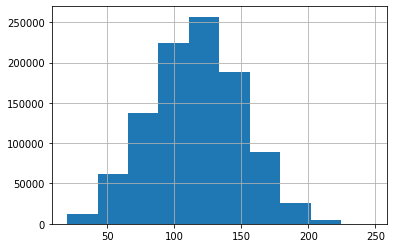

In [ ]:
#predicted salaries 
test_salaries.hist()

In [ ]:
# summary of the prediction column
test_salaries.describe()

count    1000000.000000
mean         116.059937
std           33.777901
min           20.202682
25%           92.825012
50%          116.512398
75%          139.360821
max          247.161896
Name: predictions, dtype: float64

In [ ]:
best_model.fit(x_tr, y_tr, early_stopping_rounds=10, eval_set=eval_set, verbose=True)

[02:29:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:111.393	validation_1-rmse:111.504
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:101.909	validation_1-rmse:102.019
[2]	validation_0-rmse:93.3229	validation_1-rmse:93.4443
[3]	validation_0-rmse:85.5432	validation_1-rmse:85.6629
[4]	validation_0-rmse:78.5088	validation_1-rmse:78.6252
[5]	validation_0-rmse:72.1602	validation_1-rmse:72.2802
[6]	validation_0-rmse:66.4276	validation_1-rmse:66.546
[7]	validation_0-rmse:61.2603	validation_1-rmse:61.3789
[8]	validation_0-rmse:56.6159	validation_1-rmse:56.7328
[9]	validation_0-rmse:52.4414	validation_1-rmse:52.5584
[10]	validation_0-rmse:48.6979	validation_1-rmse:48.8135
[11]	validation_0-rmse:45.3444	validation_1-rmse:45.46
[12]	validation_0-rmse:42.3414	validation_1

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.09, max_delta_step=0,
             max_depth=5, min_child_weight=5, missing=None, n_estimators=440,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

Best early stopping round is 269

### ---- 12 Deploy solution ----

In [ ]:
# To convert test_salaries into a csv file
test['predictions'] = pred
test_salaries = test['predictions']
test_salaries.to_csv('test_salaries.csv')

In [ ]:
from google.colab import files # To download the csv file
files.download('test_salaries.csv')

In [ ]:
# Visualizing the predicted salaries
test_salaries.hist()
test_salaries.describe()

companyId              0.000300
jobType                0.360836
degree                 0.048311
major                  0.035029
industry               0.064927
yearsExperience        0.134958
milesFromMetropolis    0.068280
edu_level              0.287358
dtype: float32


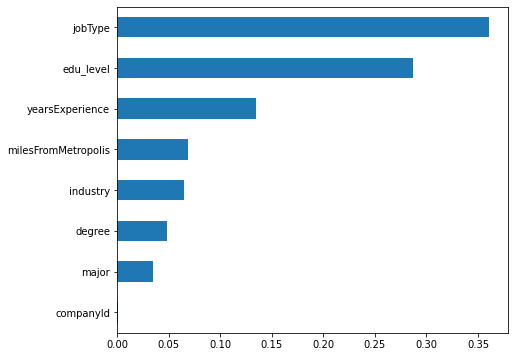

In [ ]:
# Let us see feature importance with xg boost
feature_importances = pd.Series(best_model.feature_importances_, index=x_tr.columns)
print(feature_importances)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind='barh', figsize=(7,6))

The new feature column edu_level is an important predictor for this model.

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data